<a href="https://colab.research.google.com/github/rengeruge/Colab/blob/main/DEM%E5%A4%89%E6%8F%9B%E3%83%84%E3%83%BC%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import io
from osgeo import gdal, gdalconst, gdal_array, osr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


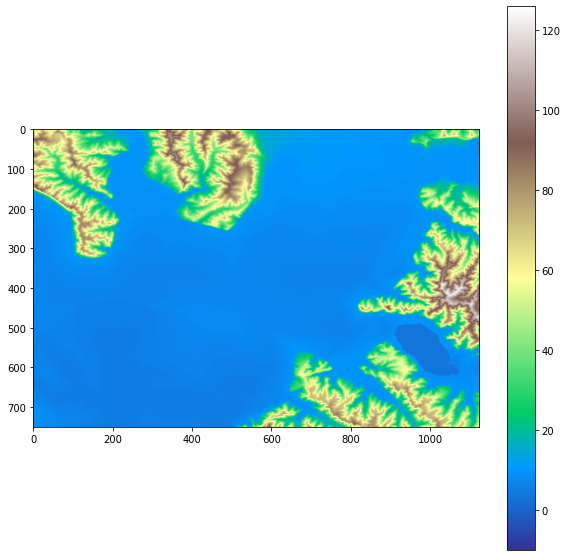

In [9]:
# 基盤地図情報DEM XMLを結合するプログラム
# 10mメッシュバージョン

import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import zipfile
import sys
import pandas as pd
import io
from tqdm import tqdm
import time
from osgeo import gdal, gdalconst, gdal_array, osr

# Google Colaboratoryで実行しているかローカルで実行しているかを判別する
# 
# Google Colaboratoryで実行している場合はgoogle.colabをインポートし，
# drive.mountを実行する．
# さらに作業用ディレクトリを指定する．
#
# ローカルで実行する場合は作業用ディレクトリの設定のみ実行する

is_colab = 'google.colab' in sys.modules
if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  base_dir = "/content/drive/My Drive/DEM/"
else:
  base_dir = "./DEM/"

ns = {'default': 'http://fgd.gsi.go.jp/spec/2008/FGD_GMLSchema',
  'xlink': 'http://www.w3.org/1999/xlink',
  'xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'gml': 'http://www.opengis.net/gml/3.2'}

infiles = glob.glob(base_dir + 'FG-GML-6444-53-DEM10B.zip')

dfall = pd.DataFrame()

# ここからループしてすべてのXMLファイルを変換する

for infile in tqdm(infiles):
    with zipfile.ZipFile(infile) as zf:
        for demxml in zf.namelist():
            with zf.open(demxml) as zfx:
                tree = ET.parse(zfx)
                elem = tree.getroot()

                lowercorner = elem.find('.//gml:lowerCorner', ns)
                uppercorner = elem.find('.//gml:upperCorner', ns)

                tuplelist = elem.find(".//gml:tupleList", ns)
                df = pd.read_csv(io.StringIO(tuplelist.text), header = None)
                df.columns = ['att', 'z']

                startPoint = elem.find('.//gml:startPoint', ns).text.split(' ')
                startPointX = int(startPoint[0])
                startPointY = int(startPoint[1])

                cols = int(elem.find(".//gml:high", ns).text.split(' ')[0]) + 1
                rows = int(elem.find(".//gml:high", ns).text.split(' ')[1]) + 1

                start = startPointX + (cols * startPointY)
                end = int(df.shape[0]) + start

                df['n'] = list(range(start, end))
                df['x4'] = (df['n'] % cols)
                df['y4'] = (df['n'] // cols)

                uppercorner = elem.find('.//gml:upperCorner', ns)
                lowercorner = elem.find('.//gml:lowerCorner', ns)

                ULX = float(lowercorner.text.split(' ')[1])
                ULY = float(uppercorner.text.split(' ')[0])
                LRX = float(uppercorner.text.split(' ')[1])
                LRY = float(lowercorner.text.split(' ')[0])

                mesh = elem.find('.//default:mesh', ns)
                
                df['y1'] = int(mesh.text[0:2])
                df['x1'] = int(mesh.text[2:4])
                df['y2'] = int(mesh.text[4])
                df['x2'] = int(mesh.text[5])
                df['y3'] = 0
                df['x3'] = 0

                # 10m DEM用の計算
                df['x'] = df['x4'] + (df['x2'] * 10 * cols) + (df['x1'] * 8 * 10 * cols)
                df['y'] = df['y4'] + ((10 - df['y2']) * 10 * rows) + ((100 - df['y1']) * 8 * 10 * rows)

                Xsize = (LRX - ULX) / cols
                Ysize = (ULY - LRY) / rows

                df['lon'] = ULX + df['x4'] * Xsize
                df['lat'] = ULY - df['y4'] * Ysize

                dfall = pd.concat([dfall, df])
                # データがない部分用のダミーデータを作る
                d1 = pd.DataFrame()
                d2 = pd.DataFrame()

                d1['x'] = list(range(min(df['x']), max(df['x'])))
                d1['y'] = min(df['y'])
                d1['z'] = -9999
                d2['x'] = min(df['x'])
                d2['y'] = list(range(min(df['y']), max(df['y'])))
                d2['z'] = -9999

                # ダミーデータを標高の入っているデータフレームに結合する
                dfall = pd.concat([dfall, d1, d2])

# 縦持ちデータを横持ちにピボットする
# データなしと標高値が重なる場合があるので，その場合は最大値（すなわち標高値）を残す
dem = dfall.pivot_table(index = 'y', columns = 'x', values = 'z', fill_value = -9999, aggfunc = 'max')
dem = dem.sort_index()

# 横持ちにした標高値を32ビット浮動小数点型のnp.Arrayに変換する
demp = dem.values.astype(np.float32)

# 確認のためDEMを図化する
plt.figure(figsize = (10, 10))
im = plt.imshow(demp, cmap = "terrain",vmin = -10)
plt.colorbar(im)
plt.show()

# GeoTiff書き出しのためのアフィンパラメータの設定（北西端の座標，メッシュサイズなど）
trans = [min(dfall['lon']), Xsize, 0, max(dfall['lat']), 0, -Ysize]

# 座標系の設定（EPSG:4612，JGD2000の緯度経度座標系）
srs = osr.SpatialReference()
srs.ImportFromEPSG(4612)

# GeoTiff書き出しのための準備，オブジェクトの生成と初期化
driver = gdal.GetDriverByName('GTiff')
output = driver.Create(base_dir + 'output_dem_UTM54_latlon.tif', demp.shape[1], demp.shape[0], 1, gdal.GDT_Float32)
output.GetRasterBand(1).WriteArray(demp)
output.GetRasterBand(1).SetNoDataValue(-9999)
output.SetGeoTransform(trans)
output.SetProjection(srs.ExportToWkt())

# GeoTiffに書き出して終了
output.FlushCache()
output = None

# DEMをUTM Zone 54/JGD2000に投影変換して保存する
opt = gdal.WarpOptions(dstSRS = 'EPSG:3100', srcNodata = -9999, dstNodata = -9999, outputType=gdal.GDT_Float32, xRes = 30.0, yRes = 30.0, targetAlignedPixels = 'true', resampleAlg = 'bilinear')

demnew = gdal.Warp(base_dir + 'output_dem_reprojected.tif', base_dir + 'output_dem_UTM54_latlon.tif', options = opt)
demnew.FlushCache()
demnew = None